In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob
from scipy.signal.windows import cosine, blackman
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit

In [2]:
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl


def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

In [3]:
###Opening all files for all four events:
##GW150914:
gw150914_h, dt_gw150914_h, utc_gw_150914_h = read_file('LOSC_Event_tutorial/H-H1_LOSC_4_V2-1126259446-32.hdf5')
gw150914_l, dt_gw150914_l, utc_gw_150914_l = read_file('LOSC_Event_tutorial/L-L1_LOSC_4_V2-1126259446-32.hdf5')

temp_gw150914_h, temp_gw150914_l = read_template('LOSC_Event_tutorial/GW150914_4_template.hdf5')


##LVT151012:
lvt151012_h, dt_lvt151012_h, etc_lvt151012_h = read_file('LOSC_Event_tutorial/H-H1_LOSC_4_V2-1128678884-32.hdf5')
lvt151012_l, dt_lvt151012_l, etc_lvt151012_l = read_file('LOSC_Event_tutorial/L-L1_LOSC_4_V2-1128678884-32.hdf5')

temp_lvt151012_h, temp_lvt151012_l = read_template('LOSC_Event_tutorial/LVT151012_4_template.hdf5')


##GW151226:
gw151226_h, dt_gw151226_h, utc_gw151226_h = read_file('LOSC_Event_tutorial/H-H1_LOSC_4_V2-1135136334-32.hdf5')
gw151226_l, dt_gw151226_l, utc_gw151226_l = read_file('LOSC_Event_tutorial/L-L1_LOSC_4_V2-1135136334-32.hdf5')

temp_gw151226_h, temp_gw151226_l = read_template('LOSC_Event_tutorial/GW151226_4_template.hdf5')


#GW170104:
gw170104_h, dt_gw170104_h, utc_gw170104_h = read_file('LOSC_Event_tutorial/H-H1_LOSC_4_V1-1167559920-32.hdf5')
gw170104_l, dt_gw170104_l, utc_gw170104_l = read_file('LOSC_Event_tutorial/L-L1_LOSC_4_V1-1167559920-32.hdf5')

temp_gw170104_h, temp_gw170104_l = read_template('LOSC_Event_tutorial/GW170104_4_template.hdf5')

# a)

To estimate the noise in the data, we take the power spectrum of the strain, i.e. the square of the absolute value of  Fourier Transform of the strain. Prior to the that, we window the strain, using an in-built scipy cosine window. Since we assume the noise to be stationary and Gaussian, we use a Gaussian filter to smooth it.

In [4]:
def noise(strain, wind):
    """
    Get the noise estimate of the data.
    Arguments:
     - strain: the original LIGO data. 
     - wind: the chosen window. 
    """

    window = wind(strain.size)
    
    d = strain*window
    ft_d = np.fft.rfft(d) 
    N = np.abs(ft_d)**2 #power spectrum
    
    N = gaussian_filter(N, 3) #smoothing the noise

    return N

In [5]:
###Create the noise models for all four events:
##GW150914:
Ngw150914_h = noise(gw150914_h, cosine)
Ngw150914_l = noise(gw150914_l, cosine)


##LVT151012:
Nlvt151012_h = noise(lvt151012_h, cosine)
Nlvt151012_l = noise(lvt151012_l, cosine)


##GW151226:
Ngw151226_h = noise(gw151226_h, cosine)
Ngw151226_l = noise(gw151226_l, cosine)


##GW170104:
Ngw170104_h = noise(gw170104_h, cosine)
Ngw170104_l = noise(gw170104_l, cosine)

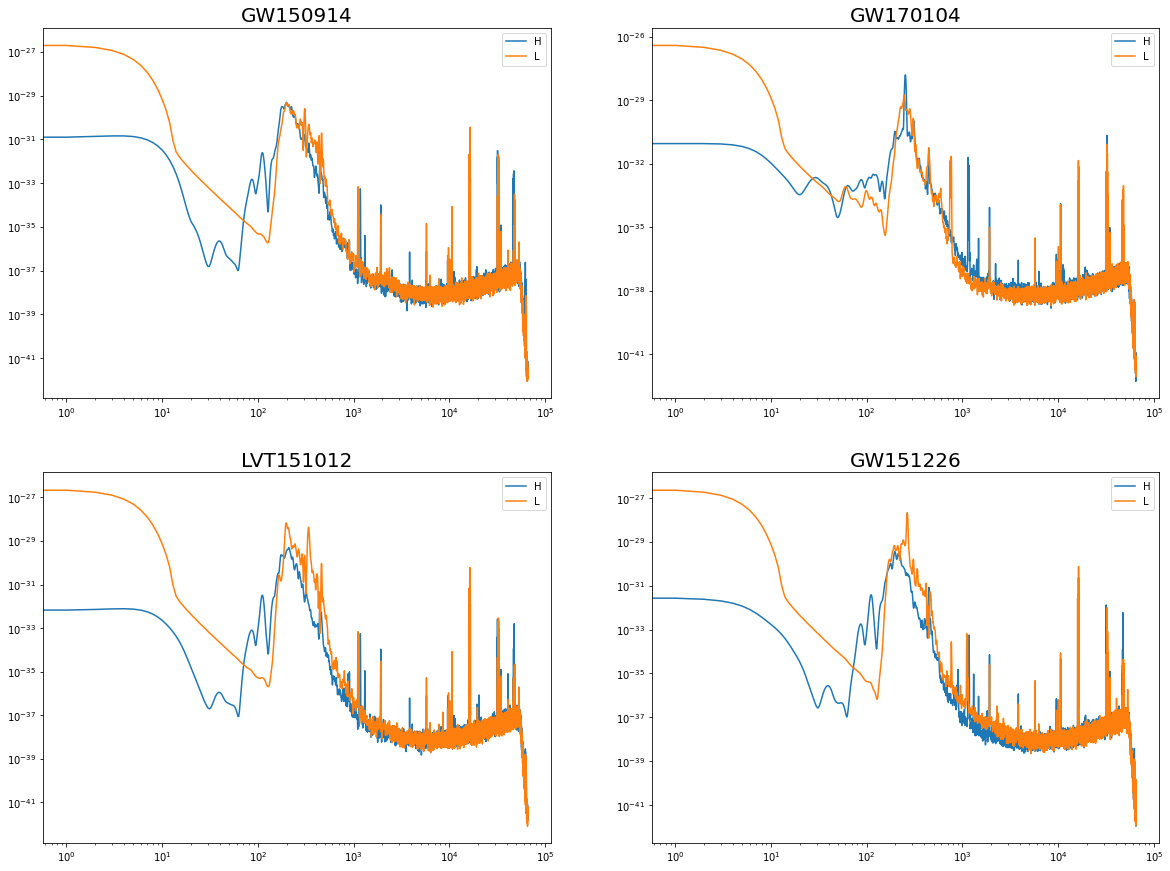

In [6]:
#Plot all eight noise models for the different strains:
fig, axes = plt.subplots(2,2, figsize=(20,15))

axes[0,0].set_title('GW150914', fontsize=20)
axes[0,0].loglog(Ngw150914_h,label='H')
axes[0,0].loglog(Ngw150914_l,label='L')
axes[0,0].legend()

axes[0,1].set_title('GW170104', fontsize=20)
axes[0,1].loglog(Ngw170104_h,label='H')
axes[0,1].loglog(Ngw170104_l,label='L')
axes[0,1].legend()

axes[1,0].set_title('LVT151012', fontsize=20)
axes[1,0].loglog(Nlvt151012_h, label='H')
axes[1,0].loglog(Nlvt151012_l, label='L')
axes[1,0].legend()

axes[1,1].set_title('GW151226', fontsize=20)
axes[1,1].loglog(Ngw151226_h, label='H')
axes[1,1].loglog(Ngw151226_l, label='L')
axes[1,1].legend()

# b) 

Using a matched filters means doing the correlation between the template and the noise estimate inversed times the strain:
corr($A;N^{-1}d$) (or equivalently corr($AN^{-1};d$) and corr($AN^{-1/2};N^{-1/2}d$)).

In [7]:
def matched_filter(A, N, strain, wind):
    """
    Gets the matched filter for a given strain.
    Arguments:
     - A: the template matching the strain.
     - N: the noise model of the strain.
     - strain: the orginal data.
     - wind: the window.
    """
    
    #Get the window
    window = wind(A.size)
    
    #Get FT of template
    wind_A = window*A
    ft_A = np.fft.rfft(wind_A)
    
    #Get FT of strain
    d = strain*window
    ft_d = np.fft.rfft(d)
    
    #Create matched filter:
    mf = np.fft.irfft(np.conj(ft_A / np.sqrt(N)) * (ft_d / np.sqrt(N)))
    
    return mf

In [8]:
###Create the matched filters for all four events:
##GW150914:
mf_gw150914_h = matched_filter(temp_gw150914_h, Ngw150914_h, gw150914_h, cosine)
mf_gw150914_l = matched_filter(temp_gw150914_l, Ngw150914_l, gw150914_l, cosine)


##LVT151012:
mf_lvt151012_h = matched_filter(temp_lvt151012_h, Nlvt151012_h, lvt151012_h, cosine)
mf_lvt151012_l = matched_filter(temp_lvt151012_l, Nlvt151012_l, lvt151012_l, cosine)


##GW151226:
mf_gw151226_h = matched_filter(temp_gw151226_h, Ngw151226_h, gw151226_h, cosine)
mf_gw151226_l = matched_filter(temp_gw151226_l, Ngw151226_l, gw151226_l, cosine)


##GW170104:
mf_gw170104_h = matched_filter(temp_gw170104_h, Ngw170104_h, gw170104_h, cosine)
mf_gw170104_l = matched_filter(temp_gw170104_l, Ngw170104_l, gw170104_l, cosine)

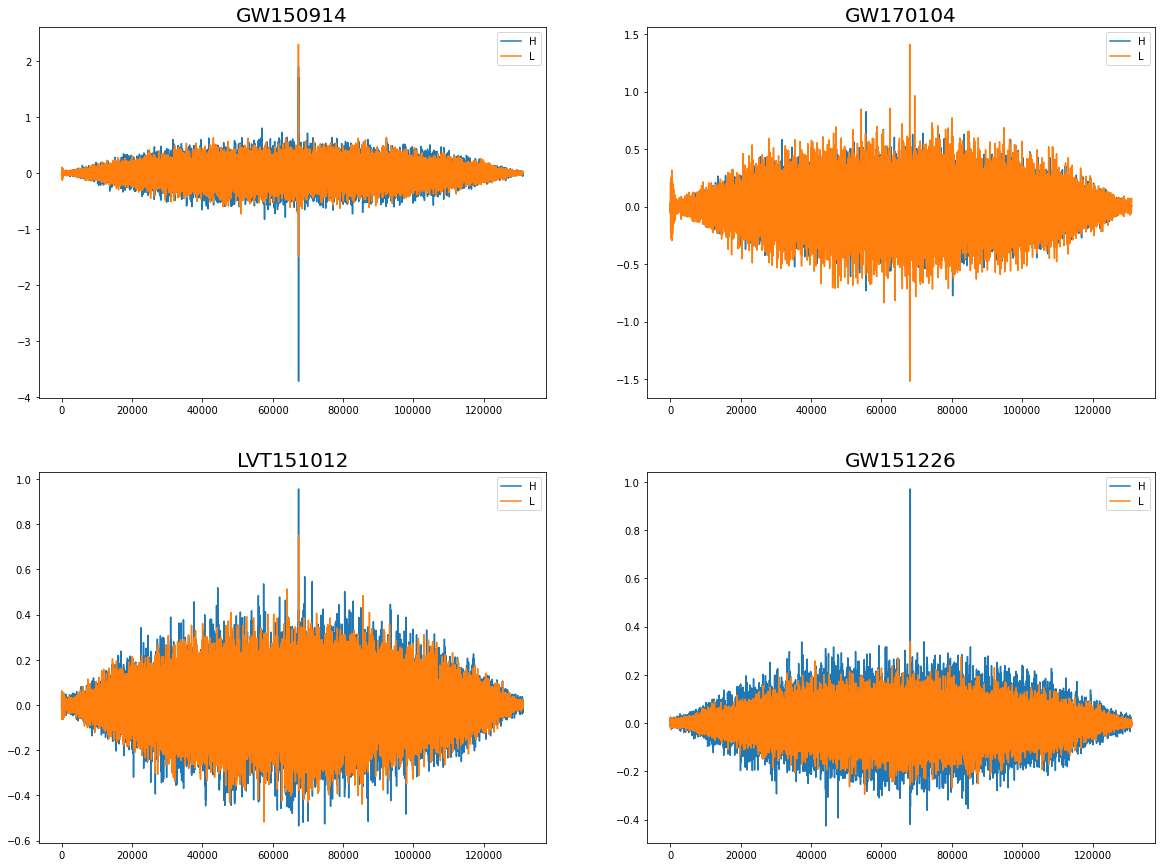

In [9]:
#Plot all matched filters:
fig, axes = plt.subplots(2,2, figsize=(20,15))

axes[0,0].set_title('GW150914', fontsize=20)
axes[0,0].plot(np.fft.fftshift(mf_gw150914_h),label='H')
axes[0,0].plot(np.fft.fftshift(mf_gw150914_l),label='L')
axes[0,0].legend()

axes[0,1].set_title('GW170104', fontsize=20)
axes[0,1].plot(np.fft.fftshift(mf_gw170104_h),label='H')
axes[0,1].plot(np.fft.fftshift(mf_gw170104_l),label='L')
axes[0,1].legend()

axes[1,0].set_title('LVT151012', fontsize=20)
axes[1,0].plot(np.fft.fftshift(mf_lvt151012_h), label='H')
axes[1,0].plot(np.fft.fftshift(mf_lvt151012_l), label='L')
axes[1,0].legend()

axes[1,1].set_title('GW151226', fontsize=20)
axes[1,1].plot(np.fft.fftshift(mf_gw151226_h), label='H')
axes[1,1].plot(np.fft.fftshift(mf_gw151226_l), label='L')
axes[1,1].legend()

We have a detection in all 4 events.

# c)

In [10]:
def SNR_scatter(mf, interval):
    """
    Get the SNR in the scatter of the matched filter.
    Arguments:
     - mf: matched filter.
     - interval: number of points to include in the standard deviation.
    """
    
    
    snr = np.max(np.abs(mf))/np.std(mf[:interval])
    return snr

In [11]:
###Get the SNR for all four events:
##GW150914:
snr_gw150914_l = SNR_scatter(mf_gw150914_l, 100)
snr_gw150914_h = SNR_scatter(mf_gw150914_h, 100)
#combined:
snr_gw150914 = np.sqrt(snr_gw150914_l**2 + snr_gw150914_h**2)

print('-----For GW150914 -----')
print('SNR Hansford:', snr_gw150914_h)
print('SNR Livingstone:', snr_gw150914_l)
print('SNR combined:', snr_gw150914)
print('\n')

##LVT151012:
snr_lvt151012_h = SNR_scatter(mf_lvt151012_h, 100)
snr_lvt151012_l = SNR_scatter(mf_lvt151012_l, 100)
#combined
snr_lvt151012 = np.sqrt(snr_lvt151012_h**2 + snr_lvt151012_l**2)

print('-----For LVT151012 -----')
print('SNR Hansford:', snr_lvt151012_h)
print('SNR Livingstone:', snr_lvt151012_l)
print('SNR combined:', snr_lvt151012)
print('\n')



##GW151226:
snr_gw151226_h = SNR_scatter(mf_gw151226_h,100)
snr_gw151226_l = SNR_scatter(mf_gw151226_l,100)
#combined
snr_gw151226 = np.sqrt(snr_gw151226_h**2 + snr_gw151226_l**2)

print('-----For GW151226 -----')
print('SNR Hansford:', snr_gw151226_h)
print('SNR Livingstone:', snr_gw151226_l)
print('SNR combined:', snr_gw151226)
print('\n')


##GW170104:
snr_gw170104_h = SNR_scatter(mf_gw170104_h, 100)
snr_gw170104_l = SNR_scatter(mf_gw170104_l, 100)
#combined
snr_gw170104 = np.sqrt(snr_gw170104_h**2 + snr_gw170104_l**2)

print('-----For GW170104 -----')
print('SNR Hansford:', snr_gw170104_h)
print('SNR Livingstone:', snr_gw170104_l)
print('SNR combined:', snr_gw170104)

-----For GW150914 -----
SNR Hansford: 14.71277037488838
SNR Livingstone: 13.49389922681048
SNR combined: 19.963740342118


-----For LVT151012 -----
SNR Hansford: 3.9459286051039095
SNR Livingstone: 5.9393943669749465
SNR combined: 7.130691271050164


-----For GW151226 -----
SNR Hansford: 13.406816453305481
SNR Livingstone: 4.309733958357319
SNR combined: 14.082490341002929


-----For GW170104 -----
SNR Hansford: 10.39057510887152
SNR Livingstone: 7.838165115816993
SNR combined: 13.015409462476038


# d)

In [12]:
def SNR_an(mf, N, A, wind):
    """
    Computes the SNR from the scatter in the matched filter.
    Arguments:
     - N: noise estimate used to get the mf.
     - A: template used to get the mf.
     - wind: chosen window.
    """
    
    #Get the window
    window = wind(A.size)
    
    #Get FT of template
    wind_A = window*A
    ft_A = np.fft.rfft(wind_A)
    
    #Compute the SNR:
    snr = (np.abs(mf))/np.sqrt(np.mean( (np.fft.irfft(ft_A / np.sqrt(N)))**2 ))

    return snr

In [13]:
###Get the analytical SNR for all four events:
##GW150914:
ansnr_gw150914_l = SNR_an(mf_gw150914_l, Ngw150914_l, temp_gw150914_l, cosine)
ansnr_gw150914_h = SNR_an(mf_gw150914_h, Ngw150914_h, temp_gw150914_h, cosine)
#combined:
ansnr_gw150914 = np.sqrt(ansnr_gw150914_l**2 + ansnr_gw150914_h**2)

print('-----For GW150914 -----')
print('Analytical SNR Hansford:', max(ansnr_gw150914_h))
print('Analytical SNR Livingstone:', max(ansnr_gw150914_l))
print('Analytical SNR combined:', max(ansnr_gw150914))
print('\n')

##LVT151012:
ansnr_lvt151012_h = SNR_an(mf_lvt151012_h, Nlvt151012_h, temp_lvt151012_h, cosine)
ansnr_lvt151012_l = SNR_an(mf_lvt151012_l, Nlvt151012_l, temp_lvt151012_l, cosine)
#combined
ansnr_lvt151012 = np.sqrt(ansnr_lvt151012_h**2 + ansnr_lvt151012_l**2)

print('-----For LVT151012 -----')
print('Analytical SNR Hansford:', max(ansnr_lvt151012_h))
print('Analytical SNR Livingstone:', max(ansnr_lvt151012_l))
print('Analytical SNR combined:', max(ansnr_lvt151012))
print('\n')



##GW151226:
ansnr_gw151226_h = SNR_an(mf_gw151226_h, Ngw151226_h, temp_gw151226_h, cosine)
ansnr_gw151226_l = SNR_an(mf_gw151226_l, Ngw151226_l, temp_gw151226_l, cosine)
#combined
ansnr_gw151226 = np.sqrt(ansnr_gw151226_h**2 + ansnr_gw151226_l**2)

print('-----For GW151226 -----')
print('Analytical SNR Hansford:', max(ansnr_gw151226_h))
print('Analytical SNR Livingstone:', max(ansnr_gw151226_l))
print('Analytical SNR combined:', max(ansnr_gw151226))
print('\n')


##GW170104:
ansnr_gw170104_h = SNR_an(mf_gw170104_h, Ngw170104_h, temp_gw170104_h, cosine)
ansnr_gw170104_l = SNR_an(mf_gw170104_l, Ngw170104_l, temp_gw170104_l, cosine)
#combined
ansnr_gw170104 = np.sqrt(ansnr_gw170104_h**2 + ansnr_gw170104_l**2)

print('-----For GW170104 -----')
print('Analytical SNR Hansford:', max(ansnr_gw170104_h))
print('Analytical SNR Livingstone:', max(ansnr_gw170104_l))
print('Analytical SNR combined:', max(ansnr_gw170104))

-----For GW150914 -----
Analytical SNR Hansford: 21.763035412701644
Analytical SNR Livingstone: 15.44934252328951
Analytical SNR combined: 21.858295060349246


-----For LVT151012 -----
Analytical SNR Hansford: 8.296244883520686
Analytical SNR Livingstone: 7.246465267247949
Analytical SNR combined: 8.303445834145846


-----For GW151226 -----
Analytical SNR Hansford: 12.319113518236707
Analytical SNR Livingstone: 6.162552886415133
Analytical SNR combined: 13.759839102154746


-----For GW170104 -----
Analytical SNR Hansford: 9.293612238642721
Analytical SNR Livingstone: 8.480955708980419
Analytical SNR combined: 10.96064611289393


The analytical SNR ratios are very similar to the ones estimated from the scatter in the matched filter. The differences can arise from the fact that the scatter SNR is dependant on the window inside which we estimate the standard deviation.

# e)

In [14]:
#Get the array of frequencies:
freq = np.fft.rfftfreq(temp_gw150914_l.size, dt_gw150914_l)

In [15]:
def half_freq(A, N, wind, f):
    """
    Get the frequency where half the weight comes from above.
    Arguments:
     - A: template for the event.
     - N: noise estimate for the event.
     - wind: window function,
     - f: array of frequencies.
    """
    
    
    window = wind(A.size)
    
    #Get FT of template
    wind_A = window*A
    ft_A = np.fft.rfft(wind_A)
    
    #Get power spectrum of template
    ps = np.abs(ft_A/np.sqrt(N))**2
    
    #Get cumulative sum:
    ps_cum = np.cumsum(ps)
    
    #Get index for half frequency:
    index = np.max(np.where((ps_cum - np.max(ps_cum)/2) <= 0))
    
    return f[index]

In [16]:
###Get the half frequency for all four events:
##GW150914:
hf_gw150914_l = half_freq(temp_gw150914_l, Ngw150914_l, cosine, freq)
hf_gw150914_h = half_freq(temp_gw150914_h, Ngw150914_h, cosine, freq)

print('-----For GW150914 -----')
print('Half frequency Hansford:', hf_gw150914_h)
print('Half frequency Livingstone:', hf_gw150914_l)
print('\n')



##LVT151012:
hf_lvt151012_h = half_freq(temp_lvt151012_h, Nlvt151012_h, cosine, freq)
hf_lvt151012_l = half_freq(temp_lvt151012_l, Nlvt151012_l, cosine, freq)

print('-----For LVT151012 -----')
print('Half frequency Hansford:', hf_lvt151012_h)
print('Half frequency Livingstone:', hf_lvt151012_l)
print('\n')



##GW151226:
hf_gw151226_h = half_freq(temp_gw151226_h, Ngw151226_h, cosine, freq)
hf_gw151226_l = half_freq(temp_gw151226_l, Ngw151226_l, cosine, freq)

print('-----For GW151226 -----')
print('Half frequency Hansford:', hf_gw151226_h)
print('Half frequency Livingstone:', hf_gw151226_l)
print('\n')



##GW170104:
hf_gw170104_h = half_freq(temp_gw170104_h, Ngw170104_h, cosine, freq)
hf_gw170104_l = half_freq(temp_gw170104_l, Ngw170104_l, cosine, freq)

print('-----For GW170104 -----')
print('Half frequency Hansford:', hf_gw170104_h)
print('Half frequency Livingstone:', hf_gw170104_l)

-----For GW150914 -----
Half frequency Hansford: 101.40625
Half frequency Livingstone: 115.78125


-----For LVT151012 -----
Half frequency Hansford: 77.25
Half frequency Livingstone: 96.25


-----For GW151226 -----
Half frequency Hansford: 75.53125
Half frequency Livingstone: 107.1875


-----For GW170104 -----
Half frequency Hansford: 92.9375
Half frequency Livingstone: 76.15625


# f)

To determine the time of arrival, I fitted a Gaussian to the peak (and area surrounding the peak) of the matched filter. The mean of the Gaussian is the time of arrival, and the sigma is the error in the time.

In [17]:
#Define gaussian function.
def Gaussian(x,μ,σ, a):
    return a * np.exp(-np.power(x - μ, 2.) / (2 * np.power(σ, 2.)))

In [20]:
#Define the time array:
time = np.arange(0, len(gw150914_h)*dt_gw150914_h, dt_gw150914_h)

In [21]:
###Fit the matched filter with a Gaussian:
h = 50 #parameter for box size for fitting


##GW150914:
#get the location of the maxium:
max_gw150914_h = np.where(np.abs(mf_gw150914_h) == np.abs(mf_gw150914_h).max())[0][0]
max_gw150914_l = np.where(np.abs(mf_gw150914_l) == np.abs(mf_gw150914_l).max())[0][0]

#fit the gaussian to the event
gw150914_h_p, pcov = curve_fit(Gaussian, time[max_gw150914_h-h:max_gw150914_h+h], np.abs(mf_gw150914_h)[max_gw150914_h-h:max_gw150914_h+h])
gw150914_l_p, pcov = curve_fit(Gaussian, time[max_gw150914_l-h:max_gw150914_l+h], np.abs(mf_gw150914_l)[max_gw150914_l-h:max_gw150914_l+h])


print('-----For GW150914 -----')
print('Arrival time Hansford: {:.3} +/- {:.1}'.format(gw150914_h_p[0], gw150914_h_p[1]))
print('Arrival time Livingstone: {:.3} +/- {:.1}'.format(gw150914_l_p[0], gw150914_l_p[1]))
print('\n')



##LVT151012:
#get the location of the maxium:
max_lvt151012_h = np.where(np.abs(mf_lvt151012_h) == np.abs(mf_lvt151012_h).max())[0][0]
max_lvt151012_l = np.where(np.abs(mf_lvt151012_l) == np.abs(mf_lvt151012_l).max())[0][0]

#fit the gaussian to the event
lvt151012_h_p, pcov = curve_fit(Gaussian, time[max_lvt151012_h-h:max_lvt151012_h+h], np.abs(mf_lvt151012_h)[max_lvt151012_h-h:max_lvt151012_h+h])
lvt151012_l_p, pcov = curve_fit(Gaussian, time[max_lvt151012_l-h:max_lvt151012_l+h], np.abs(mf_lvt151012_l)[max_lvt151012_l-h:max_lvt151012_l+h])


print('-----For GW150914 -----')
print('Arrival time Hansford: {:.4} +/- {:.1}'.format(lvt151012_h_p[0], lvt151012_h_p[1]))
print('Arrival time Livingstone: {:.4} +/- {:.1}'.format(lvt151012_l_p[0], lvt151012_l_p[1]))
print('\n')



##GW151226:
#get the location of the maxium:
max_gw151226_h = np.where(np.abs(mf_gw151226_h) == np.abs(mf_gw151226_h).max())[0][0]
max_gw151226_l = np.where(np.abs(mf_gw151226_l) == np.abs(mf_gw151226_l).max())[0][0]

#fit the gaussian to the event
gw151226_h_p, pcov = curve_fit(Gaussian, time[max_gw151226_h-h:max_gw151226_h+h], np.abs(mf_gw151226_h)[max_gw151226_h-h:max_gw151226_h+h])
gw151226_l_p, pcov = curve_fit(Gaussian, time[max_gw151226_l-h:max_gw151226_l+h], np.abs(mf_gw151226_l)[max_gw151226_l-h:max_gw151226_l+h])


print('-----For GW150914 -----')
print('Arrival time Hansford: {:.4} +/- {:.1}'.format(gw151226_h_p[0], gw151226_h_p[1]))
print('Arrival time Livingstone: {:.4} +/- {:.1}'.format(gw151226_l_p[0], gw151226_l_p[1]))
print('\n')



##GW170104:
hf_gw170104_h = half_freq(temp_gw170104_h, Ngw170104_h, cosine, freq)
hf_gw170104_l = half_freq(temp_gw170104_l, Ngw170104_l, cosine, freq)
#get the location of the maxium:
max_gw170104_h = np.where(np.abs(mf_gw170104_h) == np.abs(mf_gw170104_h).max())[0][0]
max_gw170104_l = np.where(np.abs(mf_gw170104_l) == np.abs(mf_gw170104_l).max())[0][0]

#fit the gaussian to the event
gw170104_h_p, pcov = curve_fit(Gaussian, time[max_gw170104_h-h:max_gw170104_h+h], np.abs(mf_gw170104_h)[max_gw170104_h-h:max_gw170104_h+h])
gw170104_l_p, pcov = curve_fit(Gaussian, time[max_gw170104_l-h:max_gw170104_l+h], np.abs(mf_gw170104_l)[max_gw170104_l-h:max_gw170104_l+h])


print('-----For GW150914 -----')
print('Arrival time Hansford: {:.4} +/- {:.1}'.format(gw170104_h_p[0], gw170104_h_p[1]))
print('Arrival time Livingstone: {:.4} +/- {:.1}'.format(gw170104_l_p[0], gw170104_l_p[1]))

-----For GW150914 -----
Arrival time Hansford: 0.439 +/- -0.004
Arrival time Livingstone: 0.432 +/- 0.002


-----For GW150914 -----
Arrival time Hansford: 0.4435 +/- -0.005
Arrival time Livingstone: 0.444 +/- -0.007


-----For GW150914 -----
Arrival time Hansford: 0.6455 +/- 0.008
Arrival time Livingstone: 0.6466 +/- 0.004


-----For GW150914 -----
Arrival time Hansford: 0.6084 +/- 0.005
Arrival time Livingstone: 0.6112 +/- 0.004


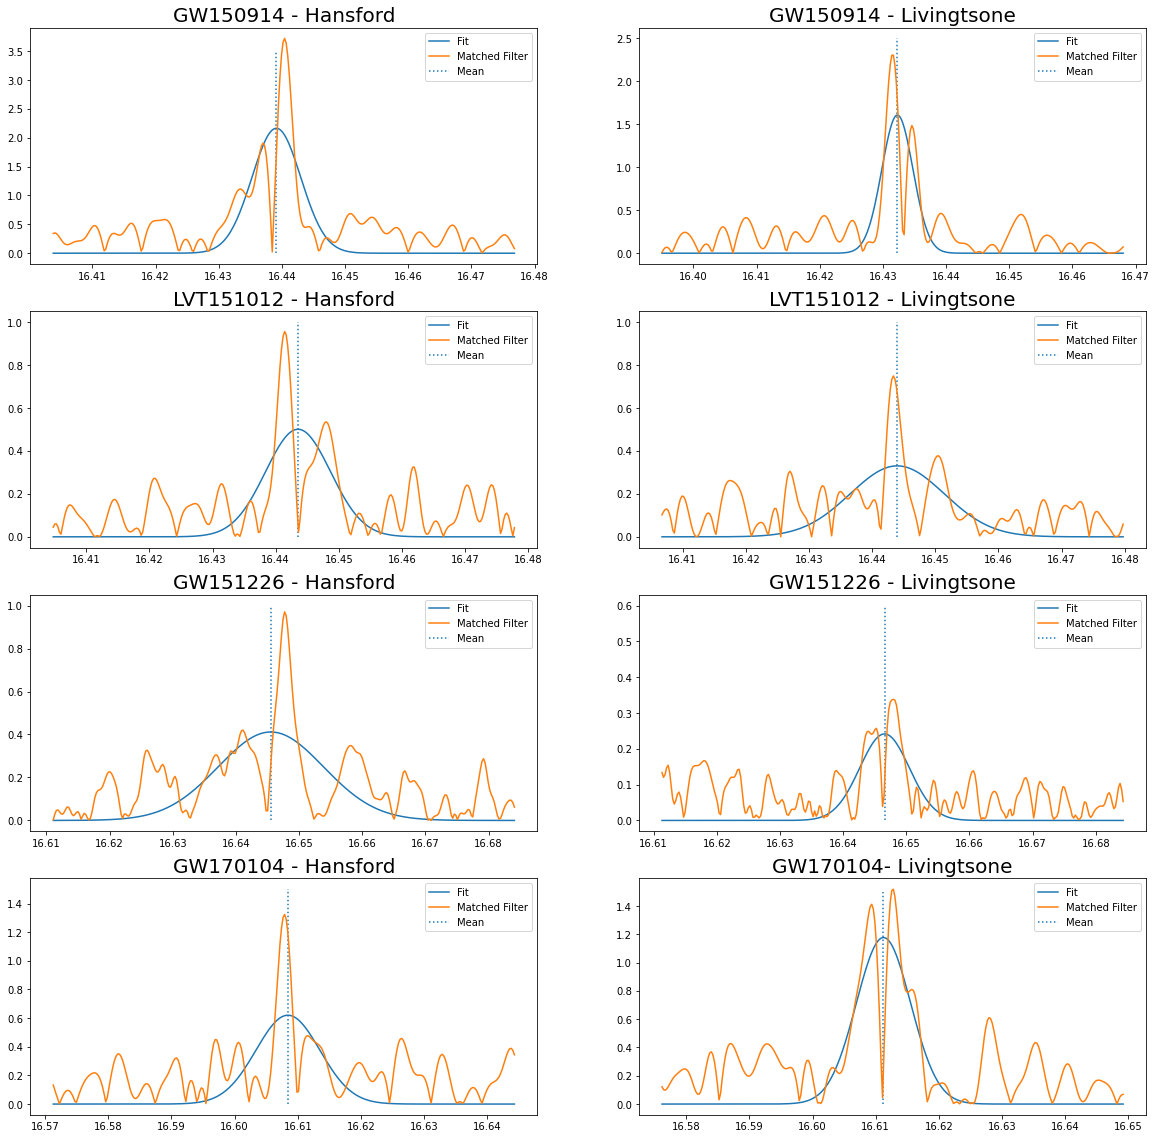

In [22]:
#Plot the results:
fig, axes = plt.subplots(4,2, figsize=(20,20))

###GW150914
axes[0,0].set_title('GW150914 - Hansford', fontsize=20)
axes[0,0].plot(np.fft.fftshift(time)[max_gw150914_h-150:max_gw150914_h+150], Gaussian(time[max_gw150914_h-150:max_gw150914_h+150], *gw150914_h_p), label='Fit')
axes[0,0].plot(np.fft.fftshift(time)[max_gw150914_h-150:max_gw150914_h+150], np.abs(mf_gw150914_h)[max_gw150914_h-150:max_gw150914_h+150], label='Matched Filter')
axes[0,0].vlines(gw150914_h_p[0]+16, 0, 3.5, linestyle=':', label='Mean')
axes[0,0].legend()

axes[0,1].set_title('GW150914 - Livingtsone', fontsize=20)
axes[0,1].plot(np.fft.fftshift(time)[max_gw150914_l-150:max_gw150914_l+150], Gaussian(time[max_gw150914_l-150:max_gw150914_l+150], *gw150914_l_p), label='Fit')
axes[0,1].plot(np.fft.fftshift(time)[max_gw150914_l-150:max_gw150914_l+150], np.abs(mf_gw150914_l)[max_gw150914_l-150:max_gw150914_l+150], label='Matched Filter')
axes[0,1].vlines(gw150914_l_p[0]+16, 0, 2.5, linestyle=':', label='Mean')
axes[0,1].legend()


###LVT151012
axes[1,0].set_title('LVT151012 - Hansford', fontsize=20)
axes[1,0].plot(np.fft.fftshift(time)[max_lvt151012_h-150:max_lvt151012_h+150], Gaussian(time[max_lvt151012_h-150:max_lvt151012_h+150], *lvt151012_h_p), label='Fit')
axes[1,0].plot(np.fft.fftshift(time)[max_lvt151012_h-150:max_lvt151012_h+150], np.abs(mf_lvt151012_h)[max_lvt151012_h-150:max_lvt151012_h+150], label='Matched Filter')
axes[1,0].vlines(lvt151012_h_p[0]+16, 0, 1., linestyle=':', label='Mean')
axes[1,0].legend()


axes[1,1].set_title('LVT151012 - Livingtsone', fontsize=20)
axes[1,1].plot(np.fft.fftshift(time)[max_lvt151012_l-150:max_lvt151012_l+150], Gaussian(time[max_lvt151012_l-150:max_lvt151012_l+150], *lvt151012_l_p), label='Fit')
axes[1,1].plot(np.fft.fftshift(time)[max_lvt151012_l-150:max_lvt151012_l+150], np.abs(mf_lvt151012_l)[max_lvt151012_l-150:max_lvt151012_l+150], label='Matched Filter')
axes[1,1].vlines(lvt151012_l_p[0]+16, 0, 1., linestyle=':', label='Mean')
axes[1,1].legend()



###GW151226
axes[2,0].set_title('GW151226 - Hansford', fontsize=20)
axes[2,0].plot(np.fft.fftshift(time)[max_gw151226_h-150:max_gw151226_h+150], Gaussian(time[max_gw151226_h-150:max_gw151226_h+150], *gw151226_h_p), label='Fit')
axes[2,0].plot(np.fft.fftshift(time)[max_gw151226_h-150:max_gw151226_h+150], np.abs(mf_gw151226_h)[max_gw151226_h-150:max_gw151226_h+150], label='Matched Filter')
axes[2,0].vlines(gw151226_h_p[0]+16, 0, 1., linestyle=':', label='Mean')
axes[2,0].legend()


axes[2,1].set_title('GW151226 - Livingtsone', fontsize=20)
axes[2,1].plot(np.fft.fftshift(time)[max_gw151226_l-150:max_gw151226_l+150], Gaussian(time[max_gw151226_l-150:max_gw151226_l+150], *gw151226_l_p), label='Fit')
axes[2,1].plot(np.fft.fftshift(time)[max_gw151226_l-150:max_gw151226_l+150], np.abs(mf_gw151226_l)[max_gw151226_l-150:max_gw151226_l+150], label='Matched Filter')
axes[2,1].vlines(gw151226_l_p[0]+16, 0, .6, linestyle=':', label='Mean')
axes[2,1].legend()




###GW170104
axes[3,0].set_title('GW170104 - Hansford', fontsize=20)
axes[3,0].plot(np.fft.fftshift(time)[max_gw170104_h-150:max_gw170104_h+150], Gaussian(time[max_gw170104_h-150:max_gw170104_h+150], *gw170104_h_p), label='Fit')
axes[3,0].plot(np.fft.fftshift(time)[max_gw170104_h-150:max_gw170104_h+150], np.abs(mf_gw170104_h)[max_gw170104_h-150:max_gw170104_h+150], label='Matched Filter')
axes[3,0].vlines(gw170104_h_p[0]+16, 0, 1.5, linestyle=':', label='Mean')
axes[3,0].legend()


axes[3,1].set_title('GW170104- Livingtsone', fontsize=20)
axes[3,1].plot(np.fft.fftshift(time)[max_gw170104_l-150:max_gw170104_l+150], Gaussian(time[max_gw170104_l-150:max_gw170104_l+150], *gw170104_l_p), label='Fit')
axes[3,1].plot(np.fft.fftshift(time)[max_gw170104_l-150:max_gw170104_l+150], np.abs(mf_gw170104_l)[max_gw170104_l-150:max_gw170104_l+150], label='Matched Filter')
axes[3,1].vlines(gw170104_l_p[0]+16, 0, 1.5, linestyle=':', label='Mean')
axes[3,1].legend()

In [23]:
#Compute the difference in arrival time:
diff_gw150914 = np.abs(gw150914_h_p[0]-gw150914_l_p[0])
ediff_gw150914 = np.sqrt(gw150914_h_p[1]**2 + gw150914_l_p[1]**2)
print('The difference in arrival time for GW150914 if {:.2} +/- {:.1} \n'.format(diff_gw150914, ediff_gw150914))

diff_lvt151012 = np.abs(lvt151012_h_p[0]-lvt151012_l_p[0])
ediff_lvt151012 = np.sqrt(lvt151012_h_p[1]**2 + lvt151012_l_p[1]**2)
print('The difference in arrival time for LVT151012 if {:.2} +/- {:.1} \n'.format(diff_lvt151012, ediff_lvt151012))

diff_gw151226 = np.abs(gw151226_h_p[0]-gw151226_l_p[0])
ediff_gw151226 = np.sqrt(gw151226_h_p[1]**2 + gw151226_l_p[1]**2)
print('The difference in arrival time for GW151226 if {:.2} +/- {:.1} \n'.format(diff_gw151226, ediff_gw151226))

diff_gw170104 = np.abs(gw170104_h_p[0]-gw170104_l_p[0])
ediff_gw170104 = np.sqrt(gw170104_h_p[1]**2 + gw170104_l_p[1]**2)
print('The difference in arrival time for GW170104 if {:.2} +/- {:.1} \n'.format(diff_gw170104, ediff_gw170104))

The difference in arrival time for GW150914 if 0.0068 +/- 0.005 

The difference in arrival time for LVT151012 if 0.00044 +/- 0.009 

The difference in arrival time for GW151226 if 0.001 +/- 0.009 

The difference in arrival time for GW170104 if 0.0028 +/- 0.007 



We can compute the minimum solid angle where the event occured through:

$$\theta = \frac{delay*c}{D}$$

Where D is the distance between the observatories (~$3\cdot10^3$km) and c the speed of light.

In [24]:
import astropy.constants as cst
import astropy.units as u

def theta(delay, D = 3e6*u.m):
    
    theta = cst.c * (delay*u.s) / D
    return theta.value

In [25]:
###Compute solid angle for all four events:
t_gw150914 = theta(diff_gw150914, D = 3e6*u.m)
print('Minimum angle for GW150914 is: {:.4}\n'.format(t_gw150914))

t_lvt151012 = theta(diff_lvt151012, D = 3e6*u.m)
print('Minimum angle for LVT151012 is: {:.4}\n'.format(t_lvt151012))

t_gw151226 = theta(diff_gw151226, D = 3e6*u.m)
print('Minimum angle for GW151226 is: {:.4}\n'.format(t_gw151226))

t_gw170104 = theta(diff_gw170104, D = 3e6*u.m)
print('Minimum angle for GW170104 is: {:.4}'.format(t_gw170104))

Minimum angle for GW150914 is: 0.6836

Minimum angle for LVT151012 is: 0.04418

Minimum angle for GW151226 is: 0.1031

Minimum angle for GW170104 is: 0.2798
